In [164]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import heapq
import random 

In [165]:
class PriorityQueue:
    def __init__(self):
        self.elements = []

    def empty(self):
        return len(self.elements) == 0

    def put(self, item, priority):
        heapq.heappush(self.elements, (priority, item))

    def get(self):
        return heapq.heappop(self.elements)[1]


In [166]:

class Node:
    def __init__(self, state, parent=None, action=None, path_cost=0):
        self.state = state  
        self.parent = parent 
        self.action = action  
        self.path_cost = path_cost  
        

    def __lt__(self, other):
        return self.path_cost < other.path_cost


In [167]:
def heuristic(a, b):
    (x1, y1) = a
    (x2, y2) = b
    return abs(x1 - x2) + abs(y1 - y2)


In [168]:
class Environment:
    def __init__(self, size = 10, start=(0,0), goal=(9,9), percent = .2):
        self.size = size
        self.grid = [[0] * size for _ in range(size)]  # make empty grid 
        self.initial = start  # set the starting point which should be pass on constructor 
        self.goal = goal       # Set the goal point which should be pass on the constructor 
        self.generate_obstacles(int((size*size)*percent))  # add random obstacle

        self.grid[start[0]][start[1]] = 0  
        self.grid[goal[0]][goal[1]] = 0 


    def generate_obstacles(self, amount):
        for _ in range(amount):
            x = random.randint(0, self.size-1)
            y = random.randint(0, self.size-1)
            self.grid[x][y] = 1

    
    def actions(self, state):
        possible_actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
        x, y = state

        if x == 0 or self.grid[x - 1][y] == 1:
            possible_actions.remove('UP')
        if x == len(self.grid) - 1 or self.grid[x + 1][y] == 1:
            possible_actions.remove('DOWN')
        if y == 0 or self.grid[x][y - 1] == 1:
            possible_actions.remove('LEFT')
        if y == len(self.grid[0]) - 1 or self.grid[x][y + 1] == 1:
            possible_actions.remove('RIGHT')

        return possible_actions

    def result(self, state, action):
        x, y = state
        if action == 'UP':
            return (x - 1, y)
        if action == 'DOWN':
            return (x + 1, y)
        if action == 'LEFT':
            return (x, y - 1)
        if action == 'RIGHT':
            return (x, y + 1)

    def is_goal(self, state):
        return state == self.goal
    # Visualization Function plots the grid and the found path.
    def display(self):
        grid_array = np.array(self.grid)  # Convert grid to numpy array for easy plotting.
        fig, ax = plt.subplots()
        ax.imshow(grid_array, cmap='Greys', alpha=0.3)  # Grid background.
        
        
        ax.set_xticks(np.arange(-.5, len(self.grid[0]), 1), minor=True)
        ax.set_yticks(np.arange(-.5, len(self.grid), 1), minor=True)
        ax.grid(which="minor", color="b", linestyle='-', linewidth=1)
        ax.tick_params(which="minor", size=0)
        ax.tick_params(which="major", bottom=False, left=False, labelbottom=False, labelleft=False)
        plt.show()
    
    def visualize_grid_and_path(self, path, Charge_station):
        grid_array = np.array(self.grid)  # Convert grid to numpy array for easy plotting.
        fig, ax = plt.subplots()
        ax.imshow(grid_array, cmap='Greys', alpha=0.3)  # Grid background.
        start = path[0]
        goal = path[-1]

        ax.plot(start[1], start[0], 'bs', markersize=10)  # Start position in blue.
        ax.plot(goal[1], goal[0], 'rs', markersize=10)  # Goal position in green.

        for charge in Charge_station:
            ax.plot(charge[1], charge[0], "ys", markersize=10)

        xs, ys = zip(*path)  # Extract X and Y coordinates of the path.
        ax.plot(ys, xs, 'g', linewidth=2)  # Plot the path in red.
        ax.set_xticks(np.arange(-.5, len(self.grid[0]), 1), minor=True)
        ax.set_yticks(np.arange(-.5, len(self.grid), 1), minor=True)
        ax.grid(which="minor", color="b", linestyle='-', linewidth=1)
        ax.tick_params(which="minor", size=0)
        ax.tick_params(which="major", bottom=False, left=False, labelbottom=False, labelleft=False)
        plt.show()

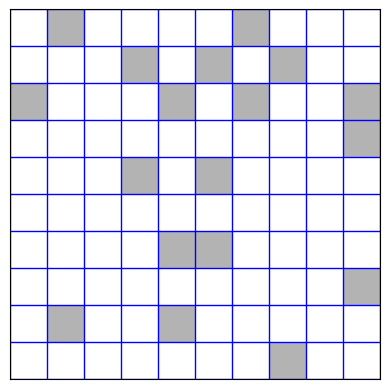

In [169]:
grid_size = 10
obstacle_probability = 0.2
start = (0,0)
goal = (grid_size-1,grid_size-1)
environment = Environment(grid_size, start, goal, obstacle_probability)

environment.display()

In [170]:
class Agent:
    def __init__(self, env):
        self.env = env

    def uniform_cost_search(self):
        frontier = PriorityQueue()  # Priority queue for UCS.
        frontier.put(Node(self.env.initial, path_cost=0), 0)
        came_from = {self.env.initial: None}
        cost_so_far = {self.env.initial: 0}
          

        while not frontier.empty():
            current_node = frontier.get()

            if self.env.is_goal(current_node.state):
                path = self.reconstruct_path(came_from, current_node.state)
                charge_station = self.charging_points(path)
                return path, charge_station
            
            for action in self.env.actions(current_node.state):
                new_state = self.env.result(current_node.state, action)
                new_cost = cost_so_far[current_node.state] + 1  # Assuming uniform cost for simplicity; adjust if varying costs.
                if new_state not in cost_so_far or new_cost < cost_so_far[new_state]:
                    cost_so_far[new_state] = new_cost
                    
                    priority = new_cost
                    frontier.put(Node(new_state, current_node, action, new_cost), priority)
                    came_from[new_state] = current_node.state

        return []

    def a_star_search(self):
        start_node = Node(self.env.initial, path_cost=0)
        frontier = PriorityQueue()
        frontier.put(start_node, 0)  
        came_from = {self.env.initial: None}  
        cost_so_far = {self.env.initial: 0} 
        
        while not frontier.empty():
            current_node = frontier.get()

            if self.env.is_goal(current_node.state):
                path = self.reconstruct_path(came_from, current_node.state)
                charge_station = self.charging_points(path)
                return path, charge_station

            for action in self.env.actions(current_node.state):
                new_state = self.env.result(current_node.state, action)
                new_cost = cost_so_far[current_node.state] + 1  
                if new_state not in cost_so_far or new_cost < cost_so_far[new_state]:
                    cost_so_far[new_state] = new_cost
                    

                    priority = new_cost + heuristic(new_state, self.env.goal)  # f-cost = g-cost + h-cost
                    frontier.put(Node(new_state, current_node, action, new_cost), priority)
                    came_from[new_state] = current_node.state

        return [],[]

    def reconstruct_path(self, came_from, current):
        path = []
        
        while current in came_from:
            path.append(current)
            current = came_from[current]
        
        path.reverse()  # Reverse to get the path from start to goal
        return path
    
    def charging_points(self, path):
        charge = 100 
        charge_station = []
        for i in range(len(path)):
            if i == 0: continue
            else: 
                charge -= 10
                if(charge == 0):
                    charge_station.append(path[i])
                    charge = 100
        return charge_station




In [171]:
agent = Agent(environment)


Path using A* Algorithm [(0, 0), (1, 0), (1, 1), (2, 1), (3, 1), (4, 1), (4, 2), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 6), (7, 6), (7, 7), (8, 7), (8, 8), (9, 8), (9, 9)]
Charge station needed on this path [(5, 5)]


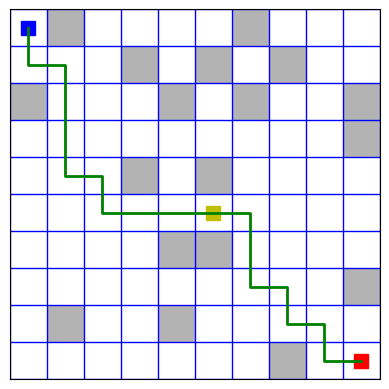

In [172]:
# Solve the problem with the A* algorithm
a_star_path, charge_station = agent.a_star_search()
if len(a_star_path):    
    print("Path using A* Algorithm",a_star_path)
    print("Charge station needed on this path",charge_station)
    environment.visualize_grid_and_path(a_star_path, charge_station)
else: 
    print("No possible path")


path using ucs algorithm [(0, 0), (1, 0), (1, 1), (2, 1), (2, 2), (2, 3), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (4, 8), (5, 8), (6, 8), (7, 8), (8, 8), (9, 8), (9, 9)]
charging station needed on this path [(3, 7)]


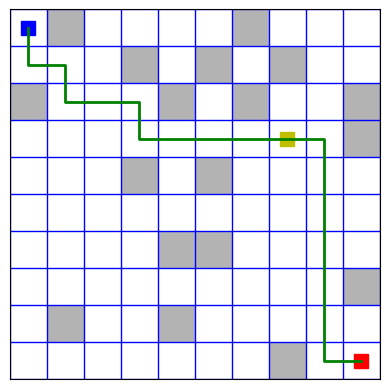

In [173]:
# Solve the problem with the UCS algorithm
ucs_path, ucs_charge_station = agent.uniform_cost_search()
if len(ucs_path):
    print("path using ucs algorithm" , ucs_path)
    print("charging station needed on this path",ucs_charge_station)
    environment.visualize_grid_and_path(ucs_path, ucs_charge_station)
else: 
    print("No possible path")


In [174]:
print("A Star Length :", len(a_star_path))
print("UCS Length :", len(ucs_path))

A Star Length : 19
UCS Length : 19
